# COSC 3337 - Fall 2024 
# Task 6 Variational AutoEncoder/Anomaly Detection
## Wikipedia Traffic Dataset
### Raunak Sarbajna

In [79]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline



In [80]:
# Load the data
data = pd.read_csv('wiki_lang_summ.csv', index_col=0)

# Preprocess the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [81]:
train_ratio = 0.75
test_ratio = 0.25

# train is now 75% of the entire data set
X_train, X_test = train_test_split(data_scaled, test_size=1 - train_ratio, shuffle=False)

print(X_train.shape)
print(X_test.shape)

(412, 7)
(138, 7)


In [82]:
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [84]:
original_dim = X_train.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)
input_shape

(7,)

## Question 3a
### Modify the final line of the sample function to add in an additional random error term. Does this increase or decrease peformance?
### Modify the following encoder layer, keeping the z_mean/z_log_var fixed. 
### You can add/remove layers, change sizes, add dropouts, before the z_mean layer.

In [83]:
# The reparameterization trick

def sample(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [85]:
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use the reparameterization trick and get the output from the sample() function
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 7)]                  0         []                            
                                                                                                  
 dense_10 (Dense)            (None, 3)                    24        ['encoder_input[0][0]']       
                                                                                                  
 z_mean (Dense)              (None, 2)                    8         ['dense_10[0][0]']            
                                                                                                  
 z_log_var (Dense)           (None, 2)                    8         ['dense_10[0][0]']            
                                                                                            

In [86]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_11 (Dense)            (None, 3)                 9         
                                                                 
 dense_12 (Dense)            (None, 7)                 28        
                                                                 
Total params: 37 (148.00 Byte)
Trainable params: 37 (148.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [87]:
# full VAE model
outputs = decoder(encoder(inputs))
vae_model = Model(inputs, outputs, name='vae_mlp')

In [88]:
# the KL loss function:
def vae_loss(x, x_decoded_mean):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var)), axis=-1)
    # return the average loss over all 
    total_loss = K.mean(reconstruction_loss + kl_loss)    
    #total_loss = reconstruction_loss + kl_loss
    return total_loss

## Question 3b
### Modify the following parameters:
#### learning rate
#### epochs
#### batch size
### Find the best values by looking at the plot in the next cell

In [89]:
opt = optimizers.legacy.Adam(learning_rate=0.001, clipvalue=0.5)
#opt = optimizers.RMSprop(learning_rate=0.0001)

vae_model.compile(optimizer=opt, loss=vae_loss)
vae_model.summary()
# Finally, we train the model:
results = vae_model.fit(X_train, X_train,
                        shuffle=True,
                        epochs=128,
                        batch_size=32)

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 7)]               0         
                                                                 
 encoder (Functional)        (None, 2)                 40        
                                                                 
 decoder (Functional)        (None, 7)                 37        
                                                                 
Total params: 77 (308.00 Byte)
Trainable params: 77 (308.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Train on 412 samples
Epoch 1/128
412/412 [==============================] - 0s 1ms/sample - loss: 15.8365
Epoch 2/128
412/412 [==============================] - 0s 39us/sample - loss: 15.1409
Epoch 3/128
412/412 [==============================] - 0s 40us/sample - loss: 14.7854
Epoch 4/1

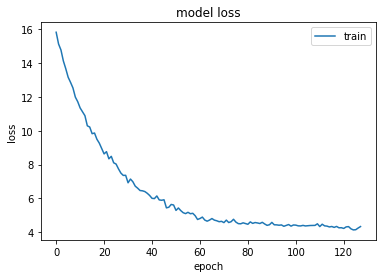

In [90]:
plt.plot(results.history['loss'])
#plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [91]:
X_train_pred = vae_model.predict(X_train)

C:\Users\Rauna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


## Question 3
### Can you find a better threshold system? Explain what you picked, or why not.

In [92]:


mae_vector = get_error_term(X_train_pred, X_train, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

error_thresh = np.quantile(mae_vector, 0.99)



Avg error 0.09169141155683853
median error 0.08069648873608978
99Q: 0.2527855459957482
setting threshold on 0.2527855459957482 


In [93]:
X_pred = vae_model.predict(X_test)
mae_vector = get_error_term(X_pred, X_test, _rmse=False)
anomalies = (mae_vector > error_thresh)

np.count_nonzero(anomalies) / len(anomalies)

0.007246376811594203

In [94]:
X_pred.shape

(138, 7)

In [95]:
X_encoded = encoder.predict(X_test)

In [96]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_transform = pca.fit_transform(X_encoded)

### Principle Component Decomposition
#### For your understanding only, nothing to do here.

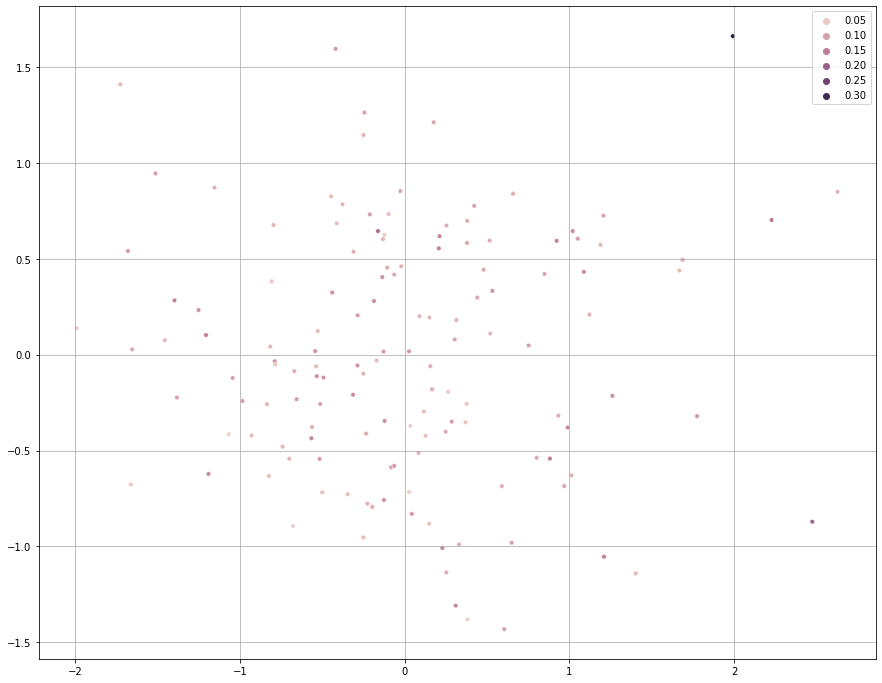

In [97]:
plt.figure(figsize=(15, 12))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector)
plt.grid()
plt.show()

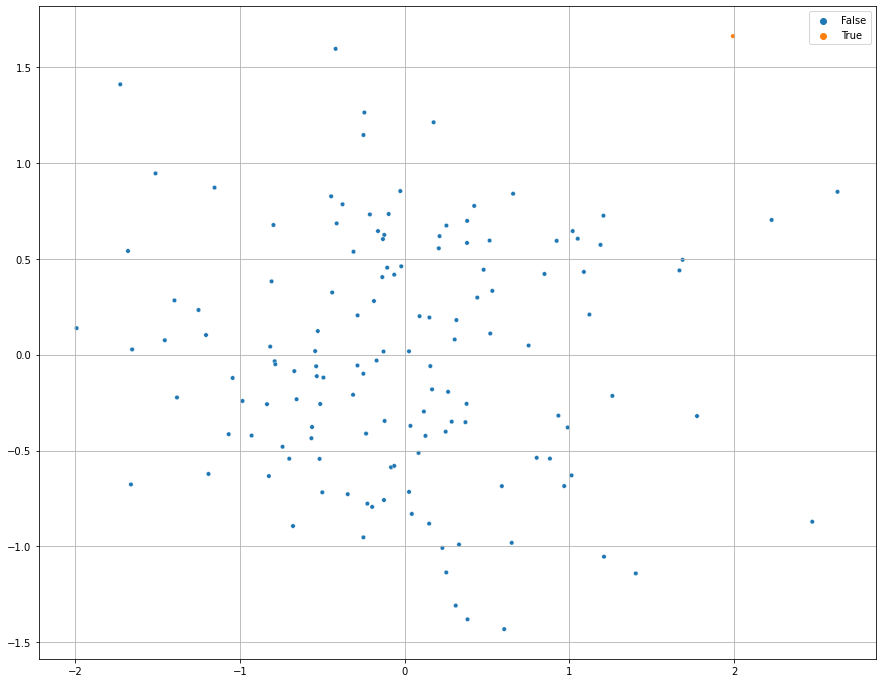

In [98]:
plt.figure(figsize=(15, 12))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=anomalies)
plt.grid()
plt.show()